<a href="https://colab.research.google.com/github/m-mejiap/TopicosAvanzadosEnAnalitica/blob/main/Proyecto%20Grafos/P2-AeropuertosBrasil-GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aeropuertos

## Descargar las librerias y la data
La base de datos que se uso es el caso de los aeropuerto de Brasil y su conexion.

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import numpy as np
import torch
import pandas as pd

from torch_geometric.datasets import Airports
dataset = Airports(root='.', name='Brazil')

In [ ]:
[i for i in dataset]

[Data(x=[131, 131], edge_index=[2, 1074], y=[131])]

In [ ]:
data = dataset[0]

In [ ]:
# Print information about the dataset
print(f'Dataset: {data}')
print('-----------------------')
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
#print(f'Number of classes: {data.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Data(x=[131, 131], edge_index=[2, 1074], y=[131])
-----------------------
Number of graphs: 3
Number of features: 131

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [ ]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: BrazilAirports()
-----------------------
Number of graphs: 1
Number of nodes: 131
Number of features: 131
Number of classes: 4


Se divide manualmente la base en tres sub bases de datos. El numero maximo es el de nodos que es 131.

In [ ]:
data.train_mask = range(31,131)
data.val_mask = range(17, 30)
data.test_mask = range(16)

##Graficos

In [ ]:
#From Tensor to DataFrame
# Tensor with edge index
data.edge_index

tensor([[  0,   0,   0,  ..., 127, 129, 130],
        [  0,   1,   2,  ..., 127,   9,  84]])

In [ ]:
# From Tensor to Numpy array
data.edge_index.numpy()

array([[  0,   0,   0, ..., 127, 129, 130],
       [  0,   1,   2, ..., 127,   9,  84]])

In [ ]:
# From Tensor to DataFrame
pd.DataFrame(data.edge_index.numpy())

,0,1,2,3,4,5,6,7,8,9,...,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073
0,0,0,0,0,0,0,0,0,0,0,...,125,125,126,127,127,127,127,127,129,130
1,0,1,2,4,5,7,15,19,21,23,...,121,125,66,42,89,123,125,127,9,84


In [ ]:
# Final transformation
pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

,start_node,end_node
0,0,0
1,0,1
2,0,2
3,0,4
4,0,5
...,...,...
1069,127,123
1070,127,125
1071,127,127
1072,129,9


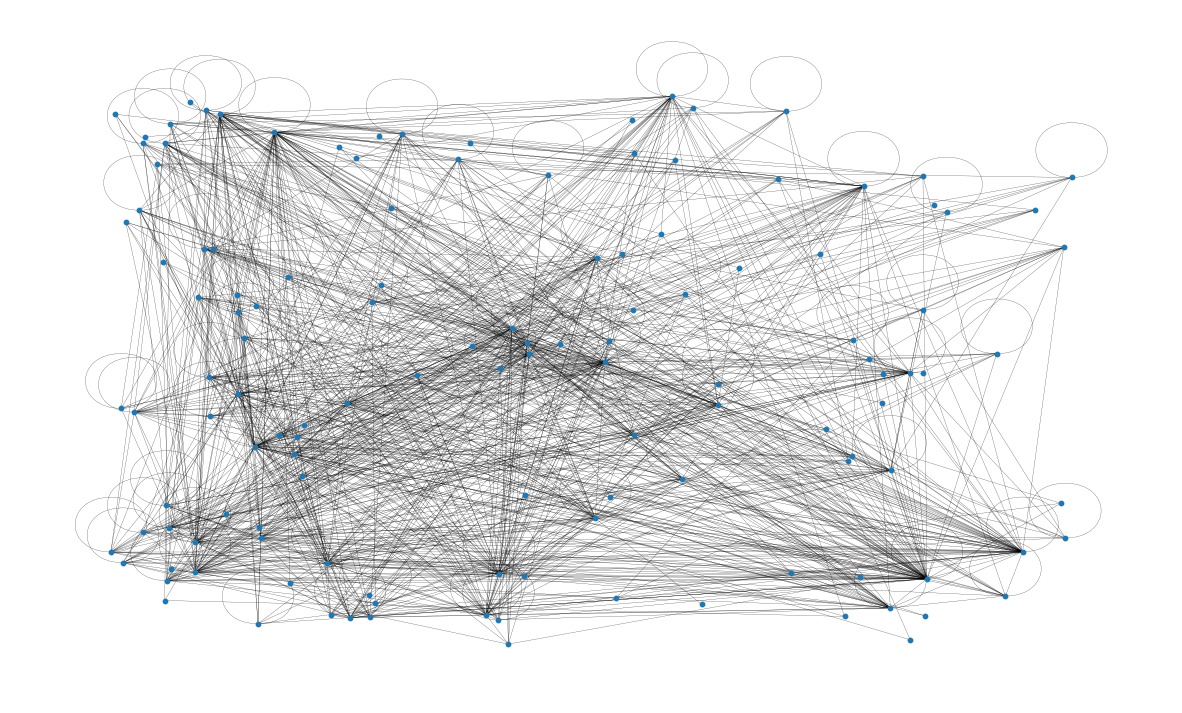

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])
G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node")
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

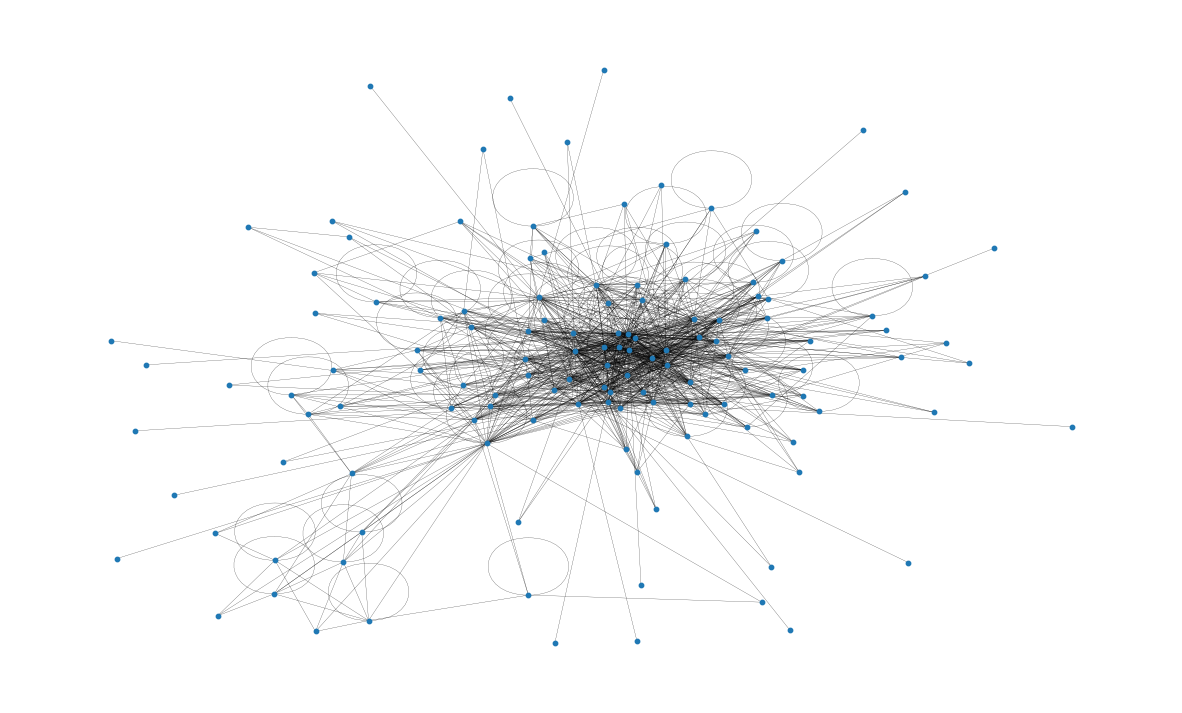

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [ ]:
# Filtering at least three connections
edge_index_list_filtered = edge_index_list.groupby("start_node").filter(lambda x: len(x) > 3)
edge_index_list_filtered.head()

,start_node,end_node
0,0,0
1,0,1
2,0,2
3,0,4
4,0,5


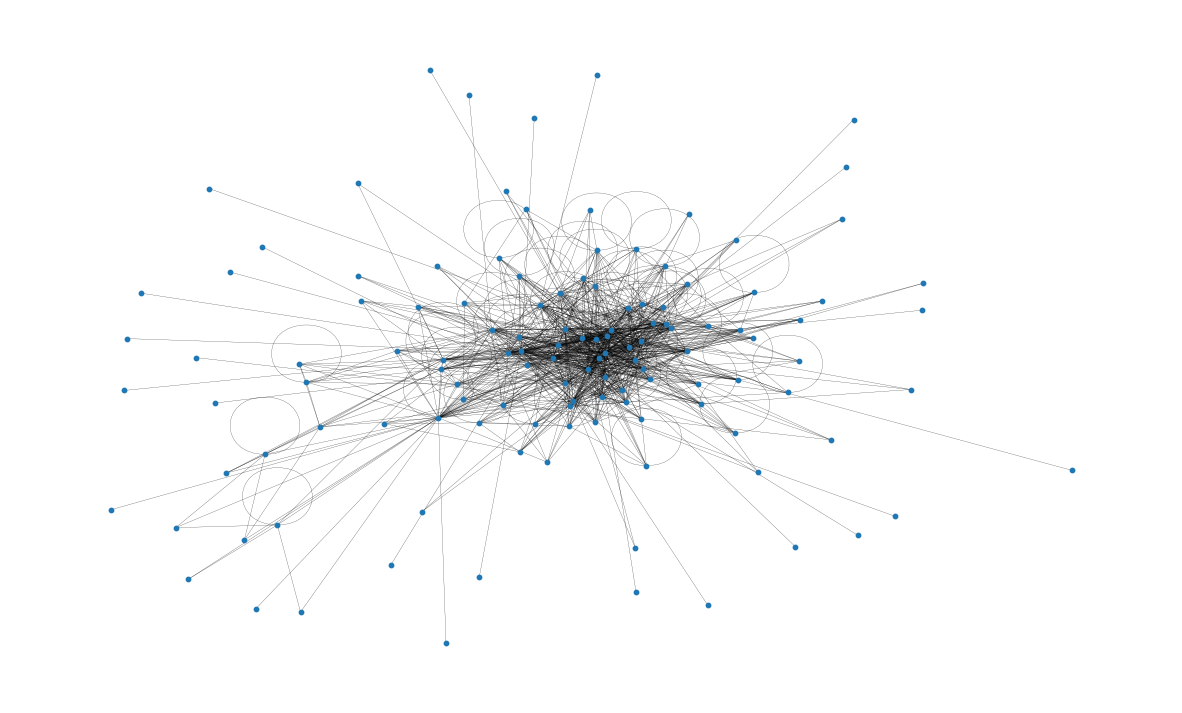

In [ ]:
G = nx.from_pandas_edgelist(edge_index_list_filtered, "start_node", "end_node")
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

##Construcción del Modelo GCN

In [ ]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

In [ ]:
def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index)
    h = torch.relu(h)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

GCN.forward = forward

In [ ]:
def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(),
                                  lr=0.01,
                                  weight_decay=5e-4)
    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                      data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(epoch % 20 == 0):
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                              data.y[data.val_mask])
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

GCN.fit = fit

In [ ]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

GCN.test = test

In [ ]:
# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

GCN(
  (gcn1): GCNConv(131, 16)
  (gcn2): GCNConv(16, 4)
)


In [ ]:
# Train
gcn.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.390 | Train Acc: 21.00% | Val Loss: 1.38 | Val Acc: 38.46%
Epoch  20 | Train Loss: 1.169 | Train Acc: 66.00% | Val Loss: 1.31 | Val Acc: 53.85%
Epoch  40 | Train Loss: 0.880 | Train Acc: 71.00% | Val Loss: 1.17 | Val Acc: 38.46%
Epoch  60 | Train Loss: 0.662 | Train Acc: 85.00% | Val Loss: 1.19 | Val Acc: 38.46%
Epoch  80 | Train Loss: 0.509 | Train Acc: 94.00% | Val Loss: 1.22 | Val Acc: 38.46%
Epoch 100 | Train Loss: 0.405 | Train Acc: 94.00% | Val Loss: 1.26 | Val Acc: 38.46%


In [ ]:
# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')


GCN test accuracy: 50.00%



##Tunnig

In [ ]:
def fit(self, data, epochs, lr=0.01, weight_decay=5e-4):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

GCN.fit = fit

In [ ]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

GCN.test = test

In [ ]:
# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

GCN(
  (gcn1): GCNConv(131, 16)
  (gcn2): GCNConv(16, 4)
)


In [ ]:
import itertools

# Rangos de hiperparámetros
learning_rates = [0.001, 0.01, 0.1, 1]
weight_decays = [1e-4, 5e-4, 1e-4, 7e-4]
epochs = [100, 200, 300]

best_accuracy = 0.0
best_params = {}


for lr, weight_decay,epochs in itertools.product(learning_rates, weight_decays,epochs):
    gcn = GCN(dataset.num_features, 16, dataset.num_classes)

    # Entrena el modelo
    gcn.fit(data, epochs=epochs, lr=lr, weight_decay=weight_decay)

    # Prueba el modelo
    acc = gcn.test(data)

    print(f'lr={lr}, weight_decay={weight_decay}, test accuracy={acc*100:.2f}%')

    # Imprimir hypeparametros
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = {'lr': lr, 'weight_decay': weight_decay,'epochs': epochs}

print(f'Best hyperparameters: {best_params}')
print(f'Best test accuracy: {best_accuracy*100:.2f}%')


lr=0.001, weight_decay=0.0001, test accuracy=18.75%
lr=0.001, weight_decay=0.0001, test accuracy=18.75%
lr=0.001, weight_decay=0.0001, test accuracy=25.00%
lr=0.001, weight_decay=0.0005, test accuracy=12.50%
lr=0.001, weight_decay=0.0005, test accuracy=25.00%
lr=0.001, weight_decay=0.0005, test accuracy=25.00%
lr=0.001, weight_decay=0.0001, test accuracy=18.75%
lr=0.001, weight_decay=0.0001, test accuracy=25.00%
lr=0.001, weight_decay=0.0001, test accuracy=25.00%
lr=0.001, weight_decay=0.0007, test accuracy=6.25%
lr=0.001, weight_decay=0.0007, test accuracy=25.00%
lr=0.001, weight_decay=0.0007, test accuracy=25.00%
lr=0.01, weight_decay=0.0001, test accuracy=43.75%
lr=0.01, weight_decay=0.0001, test accuracy=43.75%
lr=0.01, weight_decay=0.0001, test accuracy=25.00%
lr=0.01, weight_decay=0.0005, test accuracy=50.00%
lr=0.01, weight_decay=0.0005, test accuracy=31.25%
lr=0.01, weight_decay=0.0005, test accuracy=31.25%
lr=0.01, weight_decay=0.0001, test accuracy=43.75%
lr=0.01, weight_deca

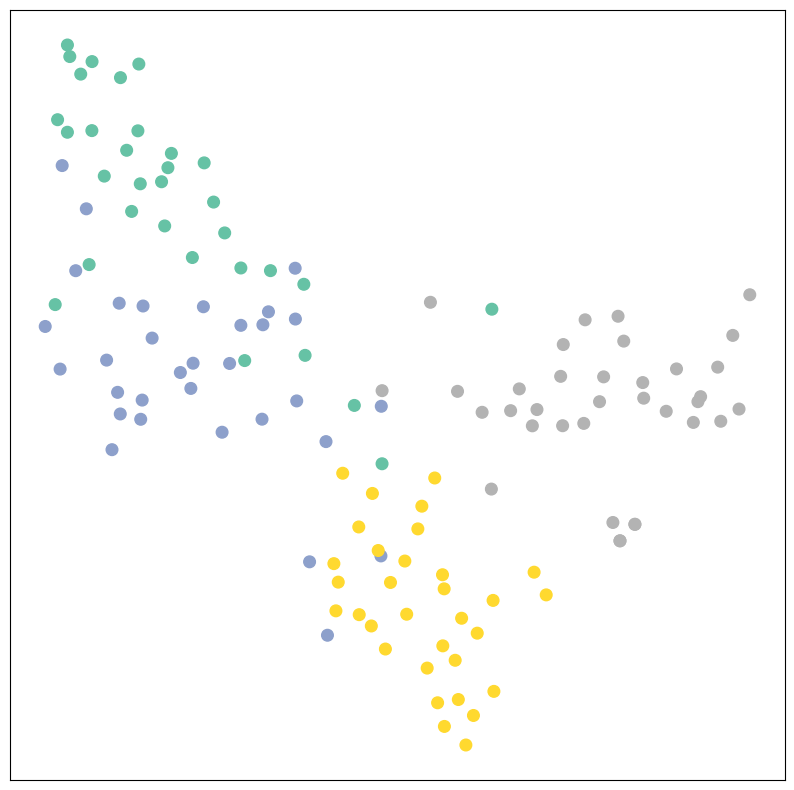

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

gcn.eval()
out = gcn(data.x, data.edge_index)
visualize(out, color=data.y)